# TODO:
    - Refine narrative
    - Make plots
    - Determine presentation form
        - Kyle: partial to some kind of web app

## Notes

- DB- Note on file names.  I slightly edited file names (I think to include a -) so the names  would be sufficiently uniform, for reading into dfs.  Let's ensure this is pushed correctly. 
- RE: CSV file inputs and date ranges.  I observe there is no 2022 autonomous vehicle disengagement report- driverless on the DMV website
- Similarily, there is something going on in the driverless mileage reports.
- The 2020-21-Autonomous-Mileage-Reports-CSV-driverless covers Jan 2020 - Nov 2021
- The 2021-22-Autonomous-Mileage-Reports-CSV-driverless covers Jan 2021 - Nov 2022, but only has 3 lines, for WERIDE CORP,
    - Which doesn't appear in the 2020-21 entry.  This is probably due to a delayed filing on their part, and staff did the ez thing.
- The 2022 Report starts in Dec 2021 - Nov 2022, and doesn't include WERIDE info (either by name or permit #)
- The 2023 Report covers Dec 2022- Nov 2023, and includes WERIDE, so there is no overlaping info.

- Re: The mileage reports.  I'm loading them in so the yeoman's work is done.  I don't want to botch joining them.
   - Some form of groupby + set_index, as per discord, might be the trick here. 
   - Alternatively, we can combine the permit # + VIN into a new single column, and this will enable some straightforward y/y granular tracking via joined dfs (m/m from Jan 2020 - Nov 2023)
- Finally, we should be on the lookout for permit #s that have company name changes, like the company got bought or something

## Narrative, high level, keep refining into story:
1. Overall trends, total miles, leaders in the space, etc.
2. Cruze story because it's interesting (backup: Waymo)
3. Follow 'zippy' the car (longest hauler)

# IMPORTS

In [2]:
import pandas as pd
import seaborn as sns 
import numpy
import plotly.express as px
from pprint import pprint
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


# DATA

In [3]:
### Lists
## Years common across data
years = ["2020", "2021", "2022", "2023"]
years = sorted(list(years))

months = ["DEC-1", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JULY", "AUG", "SEP", "OCT", "NOV"]


### Mileage

In [4]:
# TODO: Cast DATE column as datetype for disengagements

## Read in mileage data
mile_dfs = []
for year in years:
    try:
        annual_mileage = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV.csv", encoding='utf-8')
    # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_mileage = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV.csv", encoding='latin-1')
    annual_mileage["Year"] = year
    annual_mileage.rename(columns={'ANNUAL TOTAL': 'Mileage Total'}, inplace=True)
    for i, month in enumerate(months, start=4):
        annual_mileage.columns.values[i] = month
    mile_dfs.append(annual_mileage)
    # INFO: each annual report has 22 cols

mileage_df = pd.concat(mile_dfs, ignore_index=True)
# mileage_df.set_index('VIN NUMBER', inplace=True)

File for year 2020 not found. Skipping...


First Time Filers - Mileage

In [5]:
mile_first_time_filer_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-first-time-filers.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-first-time-filers.csv", encoding='latin-1')
    mile_first_time_filer_dfs.append(annual_disengagements)
    
# Not combining due to join issue raised at top of document
#first_time_mileage_df = pd.concat(mile_first_time_filer, ignore_index=True)

#print(mile_first_time_filer_dfs[0].head())
print("# of objects in mile_driverless_dfs:  " + str(len(mile_first_time_filer_dfs)))

File for year 2023-24 not found. Skipping...
# of objects in mile_driverless_dfs:  3


Driverless Mileage

In [6]:
# DB - Using the same process I used above, for Autonomous-Mileage-Reports-CSV-driverless.csv & Autonomous-Mileage-Reports-CSV-first-time-filers.csv
mile_driverless_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='latin-1')
    annual_disengagements["Year"] = year
    for i, month in enumerate(months, start=4):
        annual_disengagements.columns.values[i] = month
    mile_driverless_dfs.append(annual_disengagements)

for year in years:    
    try:
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='utf-8')
        # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
        # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='latin-1')
    annual_disengagements["Year"] = year
    for i, month in enumerate(months, start=4):
        annual_disengagements.columns.values[i] = month
    mile_driverless_dfs.append(annual_disengagements)

driverless_mileage_df = pd.concat(mile_driverless_dfs, ignore_index=True)
# TODO: deal with stupid double year file.

#print(mile_driverless_dfs[0].head())
print("# of objects in mile_driverless_dfs:  " + str(len(mile_driverless_dfs)))
driverless_mileage_df.head()


File for year 2022-23 not found. Skipping...
File for year 2023-24 not found. Skipping...
File for year 2020 not found. Skipping...
File for year 2021 not found. Skipping...
# of objects in mile_driverless_dfs:  4


,Manufacturer,Permit Number,VIN NUMBER,Annual Total of Disengagements,DEC-1,JAN,FEB,MAR,APR,MAY,...,JULY 2022,AUG 2022,SEP 2022,OCT 2022,NOV 2022,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,APOLLO AUTONOMOUS DRIVING USA LLC,AVDT006,3LN6L5LU2HR615153,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,APOLLO AUTONOMOUS DRIVING USA LLC,AVDT006,3LN6L2LU4GR629715,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,APOLLO AUTONOMOUS DRIVING USA LLC,AVDT006,2C4RC1N71LR2S2232,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CRUISE LLC,AVDT005,5G21A6P00L4100040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CRUISE LLC,AVDT005,5G21A6P01L4100029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Combined Mileage

In [7]:
# TODO Duplicate and modify code from combined disengagements here


### Disengagements

In [8]:
### Read in data
## Read in disengagements data
dis_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV.csv", encoding='utf-8')
    # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV.csv", encoding='latin-1')
    dis_dfs.append(annual_disengagements)
    
disengagement_df = pd.concat(dis_dfs, ignore_index=True)

#DB.  The unnamed column 10 only appears in the 2021 report, and the 71 entries are all for IMAGRY INC.,
# Reading "Perception" or "Planning"
# Dropped Column
disengagement_df = disengagement_df.drop('Unnamed: 9', axis=1)
#Apx 8k  empty rows.  Droped all rows with any nulls.  
disengagement_df.dropna(axis=0, how='any', inplace=True)

File for year 2020 not found. Skipping...


First Time Filers - Disengagements

In [9]:
# Adding in 1st time filer Disengagements.  Utilizing Kyle's code from above
first_time_dis_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-first-time-filers.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-first-time-filers.csv", encoding='latin-1')
    first_time_dis_dfs.append(annual_disengagements)
    
first_df = pd.concat(first_time_dis_dfs, ignore_index=True)
#Some 200ish null rows imported. Dropped any row with any missing data
first_df.dropna(axis=0, how='any', inplace=True)

File for year 2023-24 not found. Skipping...


Driverless Disengagements

In [10]:
# Driverless reports.  2022 is missing.  There are only 2 files here.  I've combined the above 2x for loops to snag them both, 
# since they have different naming conventions
driverless_dis_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='latin-1')
    driverless_dis_dfs.append(annual_disengagements)

for year in years:    
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='utf-8')
        # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
        # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='latin-1')
    driverless_dis_dfs.append(annual_disengagements)

autonomous_dis_df = pd.concat(driverless_dis_dfs, ignore_index=True)
# Dropping some 2000+ null rows.
autonomous_dis_df.dropna(axis=0, how='any', inplace=True)

File for year 2021-22 not found. Skipping...
File for year 2022-23 not found. Skipping...
File for year 2023-24 not found. Skipping...
File for year 2020 not found. Skipping...
File for year 2021 not found. Skipping...
File for year 2022 not found. Skipping...


Combined Disengagements

In [11]:
# 3x active DFs for the disengagement info are
# disengagement_df
# first_df
# autonomous_dis_df
# List of these objects to for loop the DATE cleanup.  
# IF we wanted to acccess the report source from the combined df, we could add a column to each, with the report source

# Initially had trouble by converting the dates to_datetime and then trying to drop the hour/min/sec.
# Resolved by first converting DATE to str, dropping everything after " " (since all times were separated from date by a space)
# And then subsequently converting the column to_datetime

# This works, but can't be re-run unless above code blocks that create the dfs are also re-run (I think).  
# Used print(i['DATE'].value_counts()) to confirm this came out correctly.  

disengagement_dfs_list = [disengagement_df, first_df, autonomous_dis_df]

for i in disengagement_dfs_list:
    i['DATE'] = i['DATE'].astype(str)
    i["DATE"] = i["DATE"].str.split(" ", expand=True)[0]
    i['DATE'] = pd.to_datetime(i['DATE'], errors='raise', dayfirst=True, format='mixed')

In [12]:
'''
for i in disengagement_dfs_list:
    #print(i['Permit Number'].value_counts())
    print(i.shape)
'''

# Operator-in-Vehicle = AVT Permit prefix
# NVO = AVDT Permit Prefix.
# I'm fairly certain splitting these into distinct columns for purposes of multi-indexed rows or columns is straightforward, 
# So am moving forward with data cleaning

"\nfor i in disengagement_dfs_list:\n    #print(i['Permit Number'].value_counts())\n    print(i.shape)\n"

In [13]:
# 3x disengagement df's combined together into one, single column for all permit info
combined_dis_df = pd.concat(disengagement_dfs_list, ignore_index=True)


# Data Cleaning and QA

Drop Columns

In [14]:
# What are "Unnamed" colums? Probably useless "reserved"
# This and below are from kyle, and deal with the initial mileage_df
unnamed_cols = ['Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']
for check in unnamed_cols:
    non_null_count = mileage_df[check].notna().sum()
    print(f'Number of non values in {check}: {non_null_count}')

# Empty. Drop 'em
mileage_df = mileage_df.drop(columns=unnamed_cols)
mileage_df.columns


Number of non values in Unnamed: 17: 0
Number of non values in Unnamed: 18: 0
Number of non values in Unnamed: 19: 0
Number of non values in Unnamed: 20: 0
Number of non values in Unnamed: 21: 0


Index(['Manufacturer', 'Permit Number', 'VIN NUMBER',
       'Annual Total of Disengagements', 'DEC-1', 'JAN', 'FEB', 'MAR', 'APR',
       'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'Mileage Total',
       'Year'],
      dtype='object')

Set Types

In [15]:
### Mileage
print(f'Before: {mileage_df.dtypes}')
cast_as_float = [
       'Annual Total of Disengagements', 'DEC-1', 'JAN', 'FEB', 'MAR', 'APR',
       'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'Mileage Total',
       ]

for col in cast_as_float:
    mileage_df[col] = mileage_df[col].apply(lambda x: x.replace(',', '').replace(' ', '') if isinstance(x, str) else x)
    mileage_df[col] = mileage_df[col].astype(float)

# Assuming df is your DataFrame and 'Column_Name' is the name of the column you want to convert to represent years
mileage_df['Year'] = pd.to_datetime(mileage_df['Year']).dt.year
mileage_df["Manufacturer"] = mileage_df["Manufacturer"].astype(str)


print(f'After: {mileage_df.dtypes}')



Before: Manufacturer                       object
Permit Number                      object
VIN NUMBER                         object
Annual Total of Disengagements    float64
DEC-1                              object
JAN                                object
FEB                                object
MAR                                object
APR                                object
MAY                                object
JUN                                object
JULY                               object
AUG                                object
SEP                                object
OCT                                object
NOV                                object
Mileage Total                      object
Year                               object
dtype: object
After: Manufacturer                       object
Permit Number                      object
VIN NUMBER                         object
Annual Total of Disengagements    float64
DEC-1                             float64
JAN  

QA: Ensure sum of monthly miles still equals Annual totals after column shuffling

In [16]:
### QA the monthly vs sum values
# Calculate the sum of values in the month columns for each row
month_sums = mileage_df.iloc[:, 4:-2].sum(axis=1)  

# Calculate the absolute difference between the sum of month columns and the "Mileage Total" column
absolute_difference = abs(month_sums - mileage_df['Mileage Total'])

# Check if the absolute difference is less than or equal to 2.0
within_tolerance = absolute_difference <= 2.0
fishy = (~within_tolerance).sum()
print("Number of rows where months do not add up to within 1.0 of annual total:", fishy)

# Print rows where the absolute difference is not within 2.0
# print(mileage_df[~within_tolerance])
qa = mileage_df[~within_tolerance]
print(f'Rows where MileageTotal is null: {qa["Mileage Total"].isnull().sum()}')
qa.head()


# count all nulls 
print(mileage_df.isnull().sum())
mileage_df.dropna(subset=['Mileage Total'], inplace=True)
# Drops majority of other nulls
print(mileage_df.isnull().sum())


Number of rows where months do not add up to within 1.0 of annual total: 78
Rows where MileageTotal is null: 77
Manufacturer                       0
Permit Number                     30
VIN NUMBER                        30
Annual Total of Disengagements    30
DEC-1                             30
JAN                               30
FEB                               31
MAR                               31
APR                               31
MAY                               31
JUN                               32
JULY                              32
AUG                               33
SEP                               32
OCT                               33
NOV                               32
Mileage Total                     77
Year                               0
dtype: int64
Manufacturer                      0
Permit Number                     0
VIN NUMBER                        0
Annual Total of Disengagements    0
DEC-1                             0
JAN                          

Rename Columns

In [17]:
combined_dis_df.rename(columns = {"Manufacturer" : "OPERATOR",
                                  "DISENGAGEMENT\nLOCATION\n(Interstate, Freeway, Highway, Rural Road, Street, or Parking Facility)" : "DISENGAGEMENT LOCATION", 
                                  "DISENGAGEMENT INITIATED BY\n(AV System, Test Driver, Remote Operator, or Passenger)" : "INITIATED BY",
                                  "DRIVER PRESENT\n(Yes or No)" : "DRIVER PRESENT",
                                  "VEHICLE IS CAPABLE OF OPERATING WITHOUT A DRIVER\n(Yes or No)" : "NVO CAPABLE"}, inplace=True)


mileage_df.rename(columns = {"Manufacturer" : "OPERATOR"}, inplace=True)
combined_dis_df.head(10)



,OPERATOR,Permit Number,DATE,VIN NUMBER,NVO CAPABLE,DRIVER PRESENT,INITIATED BY,DISENGAGEMENT LOCATION,DESCRIPTION OF FACTS CAUSING DISENGAGEMENT
0,AIMOTIVE INC.,AVT036,2021-04-03,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,During an exit/merge the test vehicle was goin...
1,AIMOTIVE INC.,AVT036,2021-03-16,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,"Exit/Merge Lane departure, due to the car miss..."
2,AIMOTIVE INC.,AVT036,2021-03-16,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,"Exit/Merge Lane departure, due to the car miss..."
3,AIMOTIVE INC.,AVT036,2021-03-16,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,During an exit/merge the test vehicle was goin...
4,AIMOTIVE INC.,AVT036,2021-02-04,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,"The car should have stayed in the left lane, b..."
5,AIMOTIVE INC.,AVT036,2021-02-04,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,"Exit/Merge Lane departure, due to the car miss..."
6,AIMOTIVE INC.,AVT036,2021-04-13,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,During an exit/merge the test vehicle was goin...
7,AIMOTIVE INC.,AVT036,2021-04-14,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,During an exit/merge the test vehicle was goin...
8,AIMOTIVE INC.,AVT036,2021-04-16,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,During an exit/merge the test vehicle was goin...
9,AIMOTIVE INC.,AVT036,2021-04-16,JTDKN3DU9A0059509,No,Yes,Test Driver,Freeway,"The car should have stayed in the left lane, b..."


Reduce Duplicates

In [18]:

# DEDUPLICATOR
def polish(df, column):
   df[column]=df[column].str.upper() # Capitalize everything
   df[column] = df[column].str.replace("[.,]", "", regex=True) # Remove periods and commas 
   df[column] = df[column].str.replace(r'\b(LLC|INC)\b', '', regex=True)  # Remove "LLC" and "INC"
   df[column]=df[column].str.rstrip() # Remove trailing whitespace

   return df 

# Print statements are for verification and team review. Might leave them to show class "This is the mess of data we had to clean up" - discuss
print(f'Locations: {combined_dis_df["DISENGAGEMENT LOCATION"].nunique()} - {sorted(combined_dis_df["DISENGAGEMENT LOCATION"].unique())}')
print(f'Operators: {combined_dis_df["OPERATOR"].nunique()} - {sorted(combined_dis_df["OPERATOR"].unique())}')
print()

dis_columns_to_clean = ["DISENGAGEMENT LOCATION", "OPERATOR"]

# Deuplicate Disengagements
for i in dis_columns_to_clean:
   combined_dis_df = polish(combined_dis_df, i)
# Set VIN as Index
#combined_dis_df.set_index("VIN NUMBER", inplace=True)


print(f'Cleaned locations: {combined_dis_df["DISENGAGEMENT LOCATION"].nunique()} - {sorted(combined_dis_df["DISENGAGEMENT LOCATION"].unique())}')
print(f'Cleaned operators: {combined_dis_df["OPERATOR"].nunique()} - {sorted(combined_dis_df["OPERATOR"].unique())}')
print()

# Deduplicate Mileage
print("Original number of operators: ", mileage_df["OPERATOR"].nunique())

miles_columns_to_clean = ["OPERATOR"]

# Deuplicate Mileage
for i in miles_columns_to_clean:
   mileage_df = polish(mileage_df, i)

print("Actual number of unique operators: ", mileage_df["OPERATOR"].nunique())

operators = sorted(mileage_df["OPERATOR"].unique())
for value in operators:
    print(value)

# TODO: Mop up the last operators name alignment
# mileage_df["Manufacturer"] = mileage_df["Manufacturer"].str.replace('long_duplicates', 'shorter_version')


Locations: 15 - ['Express Way', 'Freeway', 'Freeway ', 'HIGHWAY', 'HIghway', 'Highway', 'Interstate', 'Parking Facility', 'Parking facility', 'Rural Road', 'STREET', 'Street', 'Urban', 'freeway', 'street']
Operators: 51 - ['AIMOTIVE INC.', 'APOLLO AUTONOMOUS DRIVING USA LLC', 'APPLE INC.', 'ARGO AI, LLC', 'AURORA OPERATIONS, INC.', 'AUTOX TECHNOLOGIES, INC', 'Apollo', 'BOSCH', 'CRUISE LLC', 'DEEPROUTE.AI', 'DIDI RESEARCH AMERICA LLC', 'DIDI RESEARCH AMERICA, LLC', 'Didi Research America', 'EASYMILE', 'GATIK AI INC', 'GATIK AI INC.', 'GHOST AUTONOMY INC', 'Gatik AI Inc', 'IMAGRY INC', 'IMAGRY INC ', 'IMAGRY INC.', 'INTEL CORPORATION', 'LYFT', 'MERCEDES-BENZ RESEARCH & DEVELOPMENT NORTH AMERICA, INC.', 'MOTIONAL AD, INC.', 'Motional AD, Inc.', 'NISSAN NORTH AMERICA, INC DBA ALLIANCE INNOVATION LAB', 'NURO, INC', 'NVIDIA', 'NVIDIA CORPORATION ', 'Nissan North America', 'Nuro Inc', 'PONY.AI, INC.', 'QCRAFT INC.', 'QUALCOMM TECHNOLOGIES, INC.', 'TOYOTA RESEARCH INSTITUTE', 'TOYOTA RESEARCH 

### Find 'Zippy'

In [19]:
miles_by_vin = mileage_df.groupby("VIN NUMBER")["Mileage Total"].sum().sort_values(ascending=False)
miles_by_vin.head()
zippy = miles_by_vin.idxmax()
print(f'Zippy VIN is {zippy}')

print(f'Zippy is a {mileage_df.loc[mileage_df["VIN NUMBER"] == zippy, "OPERATOR"].unique()[0]} vehicle.')

Zippy VIN is SADHW2S13M1616427
Zippy is a WAYMO vehicle.


### GRAPHS

### Big Picture

In [20]:
# Create DF without zero mile cars
nonzero_mileage = mileage_df[(mileage_df["Mileage Total"] > 0)]

In [23]:
#### Histogram: miles driven / VIN ######
fig = px.histogram(nonzero_mileage,
             x='Mileage Total', color="OPERATOR", title="Autonomous Mileage by Vehicle (2021-2023)", nbins=50)
fig.update_layout(xaxis_title='Vehicle Mileage', yaxis_title='Number of Vehicles')
fig.show()

#### Histogram: miles driven / Operator ######
manufacturer_miles_sum = nonzero_mileage.groupby('OPERATOR')['Mileage Total'].sum().reset_index()

fig = px.histogram(manufacturer_miles_sum, x='Mileage Total', title='Total Miles Driven Per Operator (2021-2023)',
                   labels={'Mileage Total': 'Total Miles Driven'},  nbins=100)  # Adjust nbins as needed
fig.update_layout(yaxis_title='Operators')

fig.show()



#### WANT: Would be absolutley sick if we could start with the VINs histogram and animated into the by Operator graph...


#### Total Miles driven per year 


In [29]:
# Aggregate the sum of "Mileage Total" by "Year" and "Manufacturer"
agg_df = mileage_df.groupby(['OPERATOR', 'Year'])['Mileage Total'].sum().reset_index()

# Filter to include only data for the top 10 operators
top_10_operators = mileage_df.groupby('OPERATOR')['Mileage Total'].sum().nlargest(10).index
top_miles = agg_df[agg_df['OPERATOR'].isin(top_10_operators)]
manufacturer_order = agg_df.groupby('OPERATOR')['Mileage Total'].sum().sort_values(ascending=False).index


# Create the bar plot
fig = px.bar(top_miles, x='Year', y='Mileage Total', color='OPERATOR', text="OPERATOR", title='Annual Autonomous Mileage Totals', category_orders={'OPERATOR': manufacturer_order})
fig.update_layout(xaxis_title='Year', yaxis_title='Mileage Total')
fig.update_xaxes(tickvals=[2021, 2022, 2023])
fig.show()

### Duplicate of above, but line - Better for comparing operators
fig = px.line(top_miles, x='Year', y='Mileage Total', color='OPERATOR', text="OPERATOR", title='Annual Mileage Total by Operator')
fig.update_layout(xaxis_title='Year', yaxis_title='Mileage Total')
fig.update_xaxes(tickvals=[2021, 2022, 2023])
fig.show()

In [ ]:
### Miles driven donut by operator? only a few DOMINATE the space.
## No need? Show by above graphs?

### Disengagements across industry

In [32]:
#### DISENGAGEMENTS PER THOUSAND MILES DRIVEN
# Makes most sense to show by year on a per-company basis. 

# Group by manufacturer - get VIN count, total disengagments and total miles
dptm = nonzero_mileage.groupby(['OPERATOR', 'Year']).agg({'Mileage Total': 'sum',
                                                              'Annual Total of Disengagements': 'sum',
                                                              'VIN NUMBER': 'nunique'}).reset_index()
# Calculate DPTM
dptm["Disengagements/Thousand Miles"] = (dptm['Annual Total of Disengagements'] / (dptm['Mileage Total'] / 1000))

# Lowest DPTM Operators
smoothest_operators = dptm.groupby('OPERATOR')['Disengagements/Thousand Miles'].sum().nsmallest(10).index
# Simple Yearly Aggregate of DPTM per Operator
agg_2 = dptm.groupby(['OPERATOR', 'Year'])['Disengagements/Thousand Miles'].sum().reset_index()
# agg_2 filtered by smoothest operators (best 10)
lowest_disengage_rate = agg_2[agg_2['OPERATOR'].isin(smoothest_operators)]

# DPTM df filtered down to 10 best @ DPTM
dptm_filtered_10 = dptm[dptm['OPERATOR'].isin(smoothest_operators)]

dptm_total = nonzero_mileage.groupby(['OPERATOR']).agg({'Mileage Total': 'sum',
                                                              'Annual Total of Disengagements': 'sum'}).reset_index()
dptm_total["Disengagements/Thousand Miles"] = (dptm_total['Annual Total of Disengagements'] / (dptm_total['Mileage Total'] / 1000))

dptm_total.head()

,OPERATOR,Mileage Total,Annual Total of Disengagements,Disengagements/Thousand Miles
0,AIMOTIVE,33067.41,1494.0,45.180436
1,APOLLO,15311.70,3.0,0.195929
2,APOLLO AUTONOMOUS DRIVING USA,3944.50,1.0,0.253518
3,APPLE,591112.20,9839.0,16.644894
4,ARGO AI,55374.68,2.0,0.036118


### Graphing RATE of dsengagements against total miles


In [35]:
# Showing each operator each year - I think this is the bettter visual
fig = px.scatter(dptm, x="Mileage Total", y="Disengagements/Thousand Miles", color="OPERATOR")
fig.update_layout(title='Average Annual Disengagements Per Thousand Miles v. Total Mileage - All Opertors')
fig.show()

# Aggrgated by year
fig = px.scatter(dptm_total, x="Mileage Total", y="Disengagements/Thousand Miles", color="OPERATOR")
fig.update_layout(title='Average Disengagements Per Thousand Miles v. Total Mileage - All Opertors (2021-2023)')

fig.show()


In [ ]:
### Graphing DPTM - Mehhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh tells no story, would be a lot cooler with more years of data
fig = px.scatter(dptm, x="Mileage Total", y="Annual Total of Disengagements", 
                 size="VIN NUMBER", color="Manufacturer",
                 animation_frame="Year", animation_group="Manufacturer",
                 range_x=[0, dptm["Mileage Total"].max() * 1.1],  # Adjust range for x-axis
                 range_y=[0, dptm["Annual Total of Disengagements"].max() * 1.1],  # Adjust range for y-axis
                 labels={"Mileage Total": "Annual Mileage", "Annual Total of Disengagements": "Annual Total of Disengagements", "VIN NUMBER": "Number of Vehicles", "Manufacturer": "Manufacturer", "Year": "Year"}
                )
fig.update_layout(title='Total Disengagments vs Total Mileage [Bubble size = No. of Vehicles]')
fig.show()

Causes of Disengagement

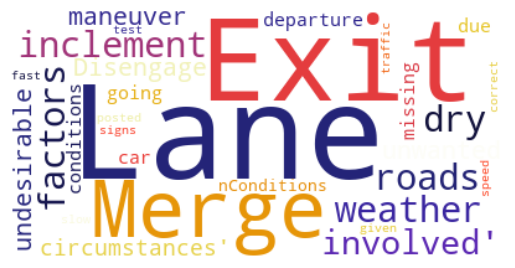

In [24]:
# Word cloud of Disengagement descriptions
text = combined_dis_df["DESCRIPTION OF FACTS CAUSING DISENGAGEMENT"].values 

stop_words = ["vehicle", "/n", "Non", "road"] + list(STOPWORDS)
wordcloud = WordCloud(stopwords = stop_words, background_color="white", colormap="CMRmap").generate(str(text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



In [ ]:
### Do the correlation thing on DPTM:

# CRUZE

# ZIPPY

In [ ]:
# graph of miles over time?
# Combined graph - line: miles, columns, disengagements?

In [ ]:
# sunburst of mileage by month? 
# what sotry? weather vehicles can/can't run in
